# Assignment 3: Traveling Salesman Problem Using Simulated Annealing

In [1]:
from functools import wraps, reduce
import math
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import time

## 0. Functions

0.1 Set up a decorator function timeit to measure and print the execution time of a wrapped function. 

In [2]:
def timeit(func):
    @wraps(func)
    def timeit_wrapper(*args, **kwargs):
        start_time = time.perf_counter()
        result = func(*args, **kwargs)
        end_time = time.perf_counter()
        total_time = end_time - start_time
        print(f'Function Took {total_time:.4f} seconds')
        return result
    return timeit_wrapper

0.2 Set up a function that reads and parses the data from tsp files, and returns the list of city coordinates.

In [3]:
def read_tsp_file(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()

    cities = []
    for line in lines:
        parts = line.split()
        if len(parts) == 3 and parts[0].isdigit():
            cities.append((float(parts[1]), float(parts[2])))

    return cities

0.3 Set up a function which normalises the list of city coordinates to 0-1 coordinates. 

In [4]:
def normalise_dist(cities):
    # lambda function to split the coordinates into separate lists, 'x_coord','y_coord' 
    devider = lambda cities: ([city[0] for city in cities], [city[1] for city in cities])
    x_coord, y_coord = devider(cities)
    # get minmax values of both coordinates
    minmax_x = (min(x_coord), max(x_coord))
    minmax_y = (min(y_coord), max(y_coord))
    # lambda functioon to normalize the coordinates with the range 
    normalizer = lambda minmax_x, x_coord: [(x - minmax_x[0]) / (minmax_x[1] - minmax_x[0]) for x in x_coord]
    # get normalized values of both coordinates 
    normalized_x = normalizer(minmax_x, x_coord)
    normalized_y = normalizer(minmax_y, y_coord)
    # lambda function to recouple normalized x and y coordinates for each city
    reconstructor = lambda a, b: (a, b)
    # final normalized list
    normalised = list(map(reconstructor, normalized_x, normalized_y))
    return normalised

0.4 Set up a function which reverses the normalization of the list of city coordinates from 0-1 coordinates back to the original values.

In [5]:
def denormalise_dist(cities, norm_coord):
    # lambda function to split the coordinates into separate lists, 'x_coord','y_coord' 
    devider = lambda cities: ([city[0] for city in cities], [city[1] for city in cities])
    x_coord, y_coord = devider(cities)
    x_norm , y_norm = devider(norm_coord)
    # get minmax values of both coordinates
    minmax_x = (min(x_coord), max(x_coord))
    minmax_y = (min(y_coord), max(y_coord))
    # lambda function to calculate the original coordinates
    denormalize = lambda minmax, norm_coords: [x * (minmax[1] - minmax[0]) + minmax[0] for x in norm_coords]
    denormalized_x = denormalize(minmax_x, x_norm)
    denormalized_y = denormalize(minmax_y, y_norm)
    # lambda function to recouple normadelized x and y coordinates for each city
    reconstructor = lambda a, b: (a, b)
    denormalised = list(map(reconstructor, denormalized_x, denormalized_y))
    return denormalised

0.5 Set up a function which calculates the total distance covered in a given tour of the cities.

In [6]:
def calculate_total_distance(tour, cities):
    total_distance = 0
    for i in range(len(tour) - 1):
        city1 = cities[tour[i]]
        city2 = cities[tour[i + 1]]
        distance = math.sqrt((city1[0] - city2[0])**2 + (city1[1] - city2[1])**2)
        total_distance += distance

    # return to the starting city
    total_distance += math.sqrt((cities[tour[-1]][0] - cities[tour[0]][0])**2 +
                                (cities[tour[-1]][1] - cities[tour[0]][1])**2)

    return total_distance

0.6. Set up functions to ammend the tours 

0.6.1 Set up a function which "moves" a single city's position within a given tour from i to j  

In [7]:
def move_city(tour):
    i, j = random.sample(range(1, len(tour)-1), 2)
    city = tour.pop(i)
    tour.insert(j, city)
    return tour

0.6.2 Set up a function which "moves" a whole section of the tour to a new (random) position 

In [8]:
def move_part(route):
    i, j = sorted(random.sample(range(1, len(route)-1), 2))
    route_slice = route[i:j]
    del route[i:j]
    if len(route) - 1 > 0:
        new_position = random.randint(1, len(route) - 1)
    else:
        new_position = 1
    route[new_position:new_position] = route_slice
    return route

0.6.3 Set up a function to implement a 2-opt swap operation for a deterministic algorithm. The 2-opt swap is a local search heuristic that attempts to improve a given route by reversing a portion of it. 

In [9]:
def two_opt(tour):
    # apply 2-opt move
    i, j = random.sample(range(len(tour)), 2)
    i, j = sorted([i, j])
    new_tour = tour[:i] + tour[i:j+1][::-1] + tour[j+1:]
    return new_tour

In [10]:
def two_opt_swap(route, i, j):
    new_route = route[:i] + route[i:j + 1][::-1] + route[j + 1:]
    return new_route

In [11]:
def optimise_with_2opt(route, cities):
    """The determenistic alg for 2-opt swap on best result."""
    improvement = True
    best_route = route
    best_distance = calculate_total_distance(route, cities)
    while improvement:
        improvement = False
        for i in range(1, len(best_route) - 1):
            for j in range(i + 1, len(best_route)):
                new_route = two_opt_swap(best_route, i, j)
                new_distance = calculate_total_distance(new_route, cities)
                if new_distance < best_distance:
                    best_distance = new_distance
                    best_route = new_route
                    improvement = True
                    break
            if improvement:
                break

    return best_route

0.7 Set up the cooling schedule functions

0.7.1 Logarithmic cooling

In [12]:
def Hoffmann_Salamon_cooling(iter, D = 10):
        return (D-1)/math.log(iter + 2)

0.7.2 Exponential cooling

In [13]:
def exponential_cooling(temp, rate):
        return temp*rate

0.7.3 Fast cooling

In [14]:
def fast_cooling(iter, initial):
        return initial/(1+iter)

0.9. Set up functions to run versions of the simulated annealing method

In [15]:
def simulated_annealing_initial(cities):
    """Simulated annealing algorithm"""
    num_cities = len(cities)
    current_tour = list(range(num_cities))
    current_distance = calculate_total_distance(current_tour, cities)
    best_tour = current_tour[:]
    best_distance = current_distance
    temp_array = []
    prob_array = []
    t = []
    fitnes = []
    fitnes_t = []
    temp_t = []
    bb = []
    temp_list = []
    p0 = 0.95
    max_length = 250
    no_progress = 0
    a = [1,1,2,3,3,4]
    """Outer loop to decrease schedule"""
    for inner_ier in range(max_length):
        new_tour = current_tour[:]
        u = random.sample(a, 1)
        if u[0] == 1:
            # 2opt swap
            tik = 1
            i, j = sorted(random.sample(range(1, num_cities), 2))
            new_tour[i:j+1] = list(reversed(new_tour[i:j+1]))
        elif u[0] == 2:
            #move city 
            tik = 2
            new_tour = move_city(new_tour)
        elif u[0] == 3:
            #move part
            tik = 3
            new_tour = move_part(new_tour)
        elif u[0] == 4:
            # Reverse two adjacent nodes
            tik = 4
            i, j = random.sample(range(1, num_cities), 2)
            tem = new_tour[i]
            try: 
                new_tour[i] = new_tour[i+1]
                new_tour[i+1] = tem
            except: 
                new_tour[i] = new_tour[i-1]
                new_tour[i-1] = tem
        # calculate the new tour distance
        new_distance = calculate_total_distance(new_tour, cities)
        delta_distance = new_distance - current_distance
        # decide whether to accept the new tour
        if delta_distance <= 0:
            fitnes.append(new_distance)
            bb.append(best_distance)
            current_tour = new_tour
            current_distance = new_distance
            # update the best tour if needed
            if new_distance < best_distance:
                best_tour = new_tour
                best_distance = new_distance
                #print(best_distance)
                no_progress =0
            else:
                no_progress += 1
        else:
                temp_list.append((-delta_distance)/np.log(p0))                     
      
    return temp_list

0.9.1 Set up the function to run the simulated annealing method on a given TSP set up, with a defined intitial temperature parameter value and cooling schedule, taking into account 2-opt and move city optimizations ('tomc')

In [16]:
def simulated_annealing_tomc(cities, initial_temperature=1000, cooling_rate=0.995, num_iterations=10000):
    num_cities = len(cities)
    current_tour = list(range(num_cities))
    random.shuffle(current_tour)
    current_distance = calculate_total_distance(current_tour, cities)

    best_tour = current_tour[:]
    best_distance = current_distance

    temperature = initial_temperature

    for iteration in range(num_iterations):
        # Choose a random elementary edit
        if random.uniform(0, 1) < 0.5:
            new_tour = two_opt(current_tour)
        else:
            new_tour = move_city(current_tour)

        # Calculate the new tour distance
        new_distance = calculate_total_distance(new_tour, cities)

        # Decide whether to accept the new tour
        if new_distance < current_distance or random.uniform(0, 1) < math.exp((current_distance - new_distance) / temperature):
            current_tour = new_tour
            current_distance = new_distance

            # Update the best tour if needed
            if new_distance < best_distance:
                best_tour = new_tour
                best_distance = new_distance

        # Cool down the temperature
        temperature *= cooling_rate

    return best_tour, best_distance

0.9.2 Set up the function to run the default simulated annealing method on a given TSP set up, with a defined intitial temperature parameter value and cooling schedule

In [17]:
@timeit
def simulated_annealing(cities, initial_temperature, cooling_rate):

    num_cities = len(cities)
    current_tour = list(range(num_cities))
    current_distance = calculate_total_distance(current_tour, cities)
    best_tour = current_tour[:]
    best_distance = current_distance
    temperature = initial_temperature
    temp_array = []
    prob_array = []
    t = []
    fitnes = []
    fitnes_t = []
    temp_t = []
    bb = []
    no_progress = 0
    
    """Outer loop for the cooling schedule"""
    for inner_ier in range(3000):
        
        a = [1,1,2,3,3,4]
        max_iterations = 3000

        """Inner loop (Markov Chain length)"""
        for iteration in range(max_iterations):
        
            new_tour = current_tour[:]
            u = random.sample(a, 1)
        
            if u[0] == 1:
            # 2opt swap
                tik = 1
                i, j = sorted(random.sample(range(1, num_cities), 2))
                new_tour[i:j+1] = list(reversed(new_tour[i:j+1]))
            elif u[0] == 2:
            # move city 
                tik = 2
                new_tour = move_city(new_tour)
            elif u[0] == 3:
            # move part
                tik = 3
                new_tour = move_part(new_tour)
            elif u[0] == 4:
                # reverse two adjacent neigbours
                tik = 4
                i, j = random.sample(range(1, num_cities), 2)
                tem = new_tour[i]
                try: 
                    new_tour[i] = new_tour[i+1]
                    new_tour[i+1] = tem
                except: 
                    new_tour[i] = new_tour[i-1]
                    new_tour[i-1] = tem
                
            # calculate the new tour distance
            new_distance = calculate_total_distance(new_tour, cities)
            delta_distance = new_distance - current_distance
        
            # decide whether to accept the new tour
            if delta_distance <= 0:
                fitnes.append(new_distance)
                fitnes_t.append((inner_ier)*max_iterations +iteration) 
                bb.append(best_distance)
                current_tour = new_tour
                current_distance = new_distance
                # update the best tour if needed
                if new_distance < best_distance:
                    best_tour = new_tour
                    best_distance = new_distance
                    print(best_distance)
                    no_progress =0
                else:
                    no_progress += 1
            else:
                no_progress += 1
                argument = -delta_distance / temperature
                random_u = random.uniform(0, 1)
                prob_array.append(math.exp(argument))
                t.append((inner_ier)*max_iterations +iteration) 
                if math.exp(argument) > random_u:
                    current_tour = new_tour
                    current_distance = new_distance

    
        temperature = exponential_cooling(temperature, cooling_rate)
        
        # reaneiling
        if temperature < 0.1 and no_progress > 50:
            best_route_2opt = optimise_with_2opt(best_tour, cities)
            best_dist_2opt = calculate_total_distance(best_route_2opt, cities)
            if best_dist_2opt == best_distance:
                temperature = 3
                print("gg")
            
        temp_array.append(temperature)
        temp_t.append(inner_ier)                       
      
    return best_tour, best_distance ,temp_array, prob_array, t, fitnes, fitnes_t, temp_t, bb

In [18]:
@timeit
def simulated_annealing_list(cities, initial_temperature, cooling_rate, colling_schedule_func, temper_list):
    """Simulated annealing algorithm"""
    num_cities = len(cities)
    current_tour = list(range(num_cities))
    current_distance = calculate_total_distance(current_tour, cities)
    best_tour = current_tour[:]
    best_distance = current_distance
    list_temper = temper_list.copy()
    temperature = np.max(list_temper)
    temp_array = []
    prob_array = []
    t = []
    fitnes = []
    fitnes_t = []
    temp_t = []
    bb = []
    no_progress = 0
    """Outer loop to decrease schedule"""
    for inner_ier in range(2000):
      """Inner loop (Markov Chain length)"""
      temp_list = []
      a = [1,1,2,3,3,4]
      inner_t = 0
      c = 0
      for iteration in range(1000):
        """new_tour1 = current_tour[:]
        new_tour2 = current_tour[:]
        new_tour3 = current_tour[:]
        new_tour4 = current_tour[:]
        u = random.sample(a, 1)
        tik = 1
        i, j = sorted(random.sample(range(1, num_cities), 2))
        new_tour1[i:j+1] = list(reversed(new_tour1[i:j+1]))
        tik = 2
        new_tour2 = move_city(new_tour2)
        tik = 3
        new_tour3 = move_part(new_tour3)
        
        tik = 4
        i, j = random.sample(range(1, num_cities), 2)
        tem = new_tour4[i]
        try: 
            new_tour4[i] = new_tour4[i+1]
            new_tour4[i+1] = tem
        except: 
            new_tour4[i] = new_tour4[i-1]
            new_tour4[i-1] = tem
        tours = [new_tour1, new_tour2, new_tour3, new_tour4]
        new_tour_arg = np.argmin([calculate_total_distance(new_tour1, cities),calculate_total_distance(new_tour1, cities),calculate_total_distance(new_tour1, cities),calculate_total_distance(new_tour1, cities)])
        new_tour = tours[new_tour_arg]"""
        new_tour = current_tour[:]
        u = random.sample(a, 1)
        if u[0] == 1:
            # 2opt swap
            tik = 1
            i, j = sorted(random.sample(range(1, num_cities), 2))
            new_tour[i:j+1] = list(reversed(new_tour[i:j+1]))
        elif u[0] == 2:
            #move city 
            tik = 2
            new_tour = move_city(new_tour)
        elif u[0] == 3:
            #move part
            tik = 3
            new_tour = move_part(new_tour)
        elif u[0] == 4:
            # Reverse two adjacent neigbours
            tik = 4
            i, j = random.sample(range(1, num_cities), 2)
            tem = new_tour[i]
            try: 
                new_tour[i] = new_tour[i+1]
                new_tour[i+1] = tem
            except: 
                new_tour[i] = new_tour[i-1]
                new_tour[i-1] = tem
        # calculate the new tour distance
        new_distance = calculate_total_distance(new_tour, cities)
        delta_distance = new_distance - current_distance
        # decide whether to accept the new tour
        if delta_distance <= 0:
            """a.append(tik)
            if len(a) >= 100:
                a = a[1:]"""
            fitnes.append(new_distance)
            fitnes_t.append((inner_ier)*2000 +iteration) 
            current_tour = new_tour
            current_distance = new_distance
            # update the best tour if needed
            if new_distance < best_distance:
                best_tour = new_tour
                best_distance = new_distance
                #print(best_distance)
                no_progress =0
            else:
                no_progress += 1
        else:
            no_progress += 1
            argument = -delta_distance / temperature
            random_u = random.uniform(0, 1)
            prob_array.append(math.exp(argument))
            t.append((inner_ier)*2000 +iteration) 
            if math.exp(argument) > random_u:
                #print((inner_t-delta_distance)/np.log(random_u))
                inner_t += (-delta_distance)/np.log(random_u)
                c +=1
                #temp_list.append((inner_t-delta_distance)/np.log(random_u))
                #temp_list.append(inner_t)
                #print(inner_t)
                current_tour = new_tour
                current_distance = new_distance

            
      #temperature = colling_schedule_func(inner_ier, initial_temperature, temperature, cooling_rate)
      if c > 0:
            list_temper.remove(max(list_temper))
            list_temper.append(inner_t/c)
            temperature = np.max(list_temper)
            #print(temperature)
      if inner_ier % 100 == 0:
                temp_array.append(temperature)
                bb.append(best_distance)
                #print(temperature)
                temp_t.append(inner_ier)      
      #temperature = exponential_cooling(temperature, cooling_rate)
      # Reannealing
      """if temperature < 0.7 and no_progress > 50:
       best_route_2opt = optimise_with_2opt(best_tour, cities)
       best_dist_2opt = calculate_total_distance(best_route_2opt, cities)
       if best_dist_2opt == best_distance or no_progress > 6000:
            temperature = 3
            print("gg")  """              
      
    return best_tour, best_distance ,temp_array, prob_array, t, fitnes, fitnes_t, temp_t, bb

In [19]:
@timeit
def simulated_annealing_cooling_check(cities, initial_temperature, cooling_rate, cool_func):
    """Simulated annealing algorithm"""
    num_cities = len(cities)
    current_tour = list(range(num_cities))
    current_distance = calculate_total_distance(current_tour, cities)
    best_tour = current_tour[:]
    best_distance = current_distance
    temperature = initial_temperature
    temp_array = []
    prob_array = []
    t = []
    fitnes = []
    fitnes_t = []
    temp_t = []
    bb = []
    no_progress = 0
    """Outer loop to decrease schedule"""
    for inner_ier in range(2000):
      a = [1,1,2,3,3,4]
      """Inner loop (Markov Chain length)"""
      for iteration in range(1000):
        new_tour = current_tour[:]
        u = random.sample(a, 1)
        if u[0] == 1:
            # 2opt swap
            tik = 1
            i, j = sorted(random.sample(range(1, num_cities), 2))
            new_tour[i:j+1] = list(reversed(new_tour[i:j+1]))
        elif u[0] == 2:
            #move city 
            tik = 2
            new_tour = move_city(new_tour)
        elif u[0] == 3:
            #move part
            tik = 3
            new_tour = move_part(new_tour)
        elif u[0] == 4:
            # Reverse two adjacent neigbours
            tik = 4
            i, j = random.sample(range(1, num_cities), 2)
            tem = new_tour[i]
            try: 
                new_tour[i] = new_tour[i+1]
                new_tour[i+1] = tem
            except: 
                new_tour[i] = new_tour[i-1]
                new_tour[i-1] = tem
        # calculate the new tour distance
        new_distance = calculate_total_distance(new_tour, cities)
        delta_distance = new_distance - current_distance
        # decide whether to accept the new tour
        if delta_distance <= 0:
            #a.append(tik)
            fitnes.append(new_distance)
            fitnes_t.append((inner_ier)*2000 +iteration) 
            current_tour = new_tour
            current_distance = new_distance
            # update the best tour if needed
            if new_distance < best_distance:
                best_tour = new_tour
                best_distance = new_distance
                #print(best_distance)
                no_progress =0
            else:
                no_progress += 1
        else:
            no_progress += 1
            argument = -delta_distance / temperature
            random_u = random.uniform(0, 1)
            prob_array.append(math.exp(argument))
            t.append((inner_ier)*2000 +iteration) 
            if math.exp(argument) > random_u:
                current_tour = new_tour
                current_distance = new_distance

            

      temperature = cool_func(inner_ier, initial_temperature, temperature, cooling_rate)
      # Reaneiling
      if temperature < 0.7 and no_progress > 6000:
        temperature = 3
        """best_route_2opt = optimise_with_2opt(best_tour, cities)
       best_dist_2opt = calculate_total_distance(best_route_2opt, cities)
       if best_dist_2opt == best_distance or no_progress > 6000:"""
      if inner_ier % 100 == 0:
                temp_array.append(temperature)
                bb.append(best_distance)
                #print(temperature)
                temp_t.append(inner_ier)  
    return best_tour, best_distance ,temp_array, prob_array, t, fitnes, fitnes_t, temp_t, bb

0.9.3 Set up the function to run the default simulated annealing method on a given TSP set up, with a defined intitial temperature parameter value and cooling schedule and a changing length of Markov chains 

In [ ]:
@timeit
def simulated_annealing_mar_len(cities, initial_temperature, cooling_rate):

    num_cities = len(cities)
    mc_iterations = 10
    best_tours_mc_l = list(range(mc_iterations))
    best_distances_mc_l = []
    temp_array_list = list(range(mc_iterations))
    temp_t_list = list(range(mc_iterations))
    prob_array_list = list(range(mc_iterations))
    t_list = list(range(mc_iterations))
    fitness_list = list(range(mc_iterations))
    fitness_t_list = list(range(mc_iterations))
    best_list = list(range(mc_iterations))

    """Lenght of Markov chain spec."""
    for l in range(mc_iterations):
        max_iterations = 500 + l * 500
        print(max_iterations)
        
        current_tour = list(range(num_cities))
        temp_array = []
        prob_array = []
        t = []
        fitnes = []
        fitnes_t = []
        temp_t = []
        bb = []
        no_progress = 0
        best_tour = current_tour[:]
        current_distance = calculate_total_distance(current_tour, cities)
        best_distance = current_distance
        temperature = initial_temperature
        
        """Outer loop for the cooling schedule"""
        for inner_ier in range(3000):

            a = [1,1,2,3,3,4]

            """Inner loop (Markov Chain length)"""
            for iteration in range(max_iterations):

                new_tour = current_tour[:]
                u = random.sample(a, 1)

                if u[0] == 1:
                # 2opt swap
                    tik = 1
                    i, j = sorted(random.sample(range(1, num_cities), 2))
                    new_tour[i:j+1] = list(reversed(new_tour[i:j+1]))
                elif u[0] == 2:
                # move city 
                    tik = 2
                    new_tour = move_city(new_tour)
                elif u[0] == 3:
                # move part
                    tik = 3
                    new_tour = move_part(new_tour)
                elif u[0] == 4:
                    # reverse two adjacent neigbours
                    tik = 4
                    i, j = random.sample(range(1, num_cities), 2)
                    tem = new_tour[i]
                    try: 
                        new_tour[i] = new_tour[i+1]
                        new_tour[i+1] = tem
                    except: 
                        new_tour[i] = new_tour[i-1]
                        new_tour[i-1] = tem

                # calculate the new tour distance
                new_distance = calculate_total_distance(new_tour, cities)
                delta_distance = new_distance - current_distance

                # decide whether to accept the new tour
                if delta_distance <= 0:
                    fitnes.append(new_distance)
                    fitnes_t.append((inner_ier)*max_iterations +iteration) 
                    bb.append(best_distance)
                    current_tour = new_tour
                    current_distance = new_distance
                    # update the best tour if needed
                    if new_distance < best_distance:
                        best_tour = new_tour
                        best_distance = new_distance
                        # print(best_distance)
                        no_progress =0
                    else:
                        no_progress += 1
                else:
                    no_progress += 1
                    argument = -delta_distance / temperature
                    random_u = random.uniform(0, 1)
                    prob_array.append(math.exp(argument))
                    t.append((inner_ier)*max_iterations +iteration) 
                    if math.exp(argument) > random_u:
                        current_tour = new_tour
                        current_distance = new_distance
                        
            temperature = exponential_cooling(temperature, cooling_rate)

            # reaneiling
            if temperature < 0.1 and no_progress > 50:
                best_route_2opt = optimise_with_2opt(best_tour, cities)
                best_dist_2opt = calculate_total_distance(best_route_2opt, cities)
                if best_dist_2opt == best_distance:
                    temperature = 3
                    print("gg")

            temp_array.append(temperature)
            temp_t.append(inner_ier) 
            
        print("Final results for MC length ", max_iterations)
        print(best_tour)
        best_tours_mc_l[l]= best_tour
        print(best_distance)
        best_distances_mc_l.append(best_distance)
        #print(temp_array)
        temp_array_list[l] = temp_array
        #print(temp_t)
        temp_t_list[l]= temp_t
        prob_array_list[l] = prob_array
        t_list[l] = t
        fitness_list[l] = fitnes
        fitness_t_list[l] = fitnes_t
        best_list[l] = bb
            
    return best_tours_mc_l,best_distances_mc_l,temp_array_list,temp_t_list, t_list, fitness_list, fitness_t_list, best_list

0.10 Set up a function to plot a given tour of the cities

In [21]:
def plot_tour(tour, cities):
    x = [cities[city][0] for city in tour]
    y = [cities[city][1] for city in tour]
    x.append(x[0])
    y.append(y[0])
    plt.figure(figsize=(8, 6))
    plt.plot(x, y, 'o-', label='Tour Path')
    plt.plot([cities[i][0] for i in range(len(cities))], 
             [cities[i][1] for i in range(len(cities))], 
             'o', label='Cities')
    
    plt.title('Traveling Salesman Problem - Simulated Annealing')
    plt.xlabel('X-coordinate')
    plt.ylabel('Y-coordinate')
    plt.legend()
    plt.show()

0.11.1 Set up a function to run multiple simulated_annealing simulations

In [22]:
def run_multiple_simulations(cities, num_simulations=100):
    best_overall_tour = None
    best_overall_distance = float('inf')

    for i in range(num_simulations):
        #print(f"Running Simulation {i + 1}")
        current_tour, current_distance = simulated_annealing(cities)
        if current_distance < best_overall_distance:
            best_overall_tour = current_tour
            best_overall_distance = current_distance

    return best_overall_tour, best_overall_distance

0.11.1 Set up a function to run multiple tomc simulated_annealing simulations

In [23]:
def run_multiple_simulations_tomc(cities, num_simulations=100):
    best_overall_tour = None
    best_overall_distance = float('inf')

    for i in range(num_simulations):
        #print(f"Running Simulation {i + 1}")
        current_tour, current_distance = simulated_annealing_tomc(cities)
        if current_distance < best_overall_distance:
            best_overall_tour = current_tour
            best_overall_distance = current_distance

    return best_overall_tour, best_overall_distance

0.12 Set up a function to find the best hyperparameters for a given TSP

In [24]:
# too long to run, delete if not used
def param_search(cities, initial_temp, cooling_rate, in_temp=0.05, col_rate=0.95, max_no_improve=30):
    """ Simulated aneiling to find best hyperparameters for TSP"""
    curr_temp = initial_temp
    curr_rate = cooling_rate
    best_tour, best_distance_init, temp_arr, prob, t, fit, ft, temp_t, best = simulated_annealing(cities, initial_temp, cooling_rate)
    
    temperature = in_temp
    best_abs = np.inf
    best_initial_temp = 0 
    best_cooling_rate = 0
    no_improve_counter = 0

    log = []

    for k in range(150):
        step_size_temp = 2.5 / (1 + k)  
        step_size_rate = 0.01 / (1 + k)  

        mean_len = []
        improved = False

        for i in range(4):
            u = random.uniform(-step_size_temp, step_size_temp) 
            new_temp = max(curr_temp + u, 0.1) 
            u = random.uniform(-step_size_rate, step_size_rate) 
            new_rate = min(max(curr_rate + u, 0.01), 0.999) 

            for b in range(7):
                best_tour, best_distance, temp_arr, prob, t, fit, ft, temp_t, best = simulated_annealing(cities, new_temp, new_rate)
                mean_len.append(best_distance)

            mean_len_v = np.mean(mean_len)
            delta_distance = mean_len_v - best_distance_init
            argument = -delta_distance / temperature
            random_u = random.uniform(0, 1)

            if delta_distance < 0 or math.exp(argument) > random_u:
                curr_temp = new_temp
                curr_rate = new_rate
                best_distance_init = mean_len_v
                print(step_size_temp)
                if best_distance_init < best_abs:
                    best_abs = best_distance_init
                    print(f"Abs best:{best_abs}")
                    print(f"cur temp:{temperature}")
                    print(f"new_temp :{new_temp}")
                    print(f"new_rate:{new_rate}")
                    best_initial_temp = curr_temp 
                    best_cooling_rate = curr_rate
                    improved = True

        log.append((k, curr_temp, curr_rate, best_abs))

        if not improved:
            no_improve_counter += 1
        else:
            no_improve_counter = 0

        if no_improve_counter >= max_no_improve:
            print("Stopping early due to no improvement.")
            break

        temperature *= col_rate

    return best_abs, best_initial_temp, best_cooling_rate, log


## 1. Test Runs: General

1.1 Test effect of delta and initial temperature on cooling schedule. 

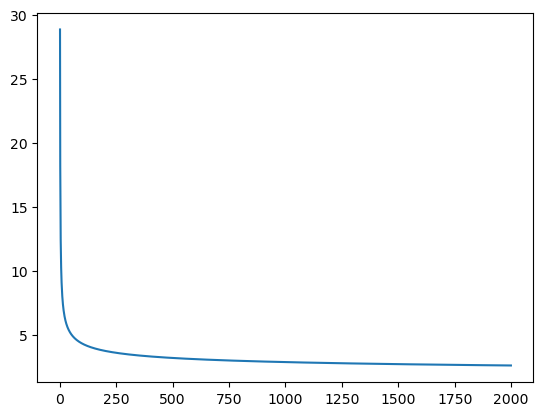

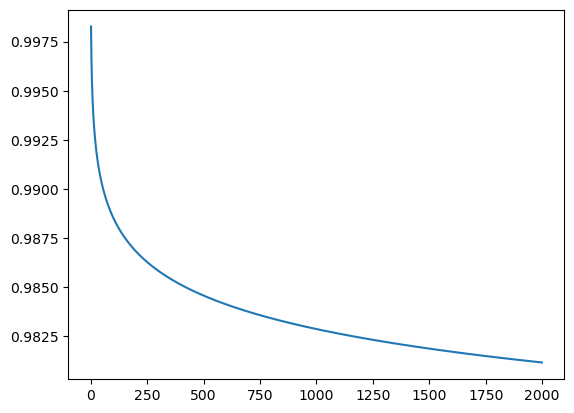

In [25]:
temperature = 20
initial_temperature = 20
ar = []
ir = []
pr = []
for i in range(1, 2000):
    temperature =  initial_temperature / (np.log(i + 1))
    ar.append(temperature)
    ir.append(i)
    argument = -0.05 / temperature
    pr.append(math.exp(argument))
plt.plot(ir, ar)
plt.show()
plt.plot(ir, pr)

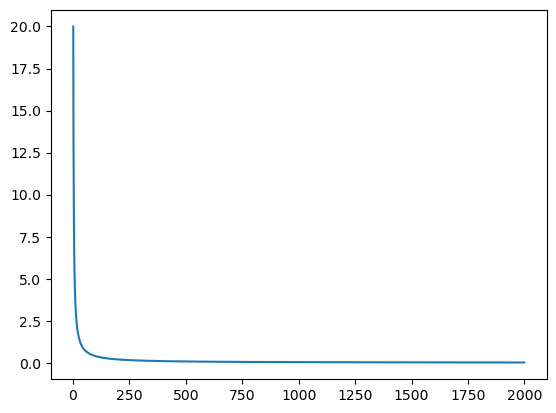

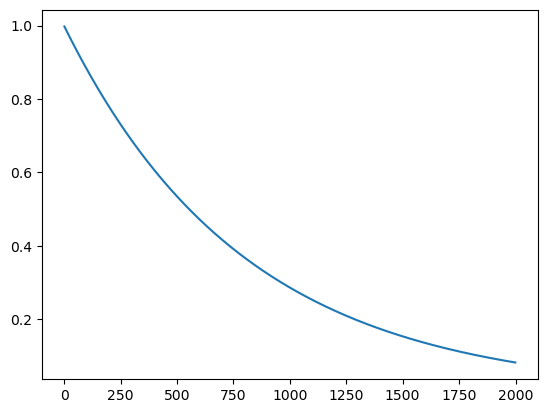

In [26]:
temperature = 20
initial_temperature = 40
ar = []
ir = []
pr = []
for i in range(1, 2000):
    temperature =  initial_temperature / (1 + i)
    ar.append(temperature)
    ir.append(i)
    argument = -0.05 / temperature
    pr.append(math.exp(argument))

plt.plot(ir, ar)
plt.show()
plt.plot(ir, pr)

## 2. Test Runs: TSP - Configuration: EIL51

In [27]:
os.getcwd()

'/Users/aleksandar/Documents/GitHub/simulated_annealing'

2.1 Set up the file extraction

In [28]:
# the path to the folder containing the csv file
folder_path = 'TSP-Configurations/'

# the name of the csv file you want to read
file_name = 'eil51.tsp.txt'

# combine the folder path and file name to create the file path
file_path = folder_path + file_name

2.2 Run the default simulated annealing simulation

2.2.1 Initialization with a fixed cooling rate

In [29]:
tsp_file_path = file_path
cities = read_tsp_file(tsp_file_path)
random.shuffle(cities)
cities_norm = normalise_dist(cities)
    
initial_temp = 1400
cooling_rate = 0.995 

2.2.2 Estimate the best tour route and distance 

In [30]:
best_tour, best_distance, temp_arr, prob, t, fit, ft, temp_t, best = simulated_annealing(cities,initial_temp,cooling_rate)

1596.67594693959
1544.2335841133686
1502.6145620347547
1491.116312229472
1461.3428418030621
1400.426004686759
1386.9490759429048
1349.8791049741958
1338.991129751019
1310.0917547198644
1303.5465385741443
1288.0354245128876
1284.6174768795836
1278.420399765135
1275.781009999601
1264.189074606994
1263.260580365664
1257.7869831755004
1251.410498261828
1216.3530620095999
1199.8282990681912
1197.5706733019285
1163.428743934367
1155.5270072953529
1155.4929242687738
1098.3962269616773
1097.2952034390173
1091.5323716167356
1088.8131827809386
1081.112447445362
1079.747037829226
1070.8040257961452
1069.7755345555247
1047.9849674572663
1030.7894727492808
1001.4938891219716
986.8601583988869
983.8080280009498
978.2473170383254
975.715280830068
974.0508645913765
968.7598511834256
963.5994321249186
963.0028979014355
946.5594089003657
943.2017389238397
940.1386482508362
914.6643332918004
898.388533295474
892.9233139860282
872.4791563004155
864.3909764300654
856.9134134310552
851.392468322226
833.9374

In [70]:
ft

[0,
 4,
 6,
 8,
 9,
 10,
 11,
 13,
 16,
 18,
 22,
 24,
 26,
 27,
 29,
 30,
 31,
 34,
 36,
 37,
 40,
 41,
 43,
 45,
 47,
 49,
 50,
 54,
 55,
 58,
 64,
 67,
 68,
 78,
 80,
 81,
 84,
 85,
 86,
 87,
 89,
 91,
 92,
 93,
 95,
 97,
 100,
 103,
 104,
 105,
 106,
 109,
 111,
 112,
 113,
 117,
 118,
 120,
 123,
 124,
 126,
 127,
 129,
 130,
 131,
 134,
 135,
 140,
 142,
 144,
 145,
 146,
 147,
 149,
 150,
 154,
 156,
 158,
 161,
 162,
 166,
 167,
 168,
 169,
 171,
 174,
 177,
 180,
 181,
 183,
 185,
 186,
 187,
 188,
 192,
 194,
 195,
 196,
 197,
 202,
 204,
 206,
 207,
 210,
 211,
 212,
 215,
 216,
 217,
 218,
 219,
 222,
 227,
 228,
 233,
 234,
 235,
 236,
 237,
 239,
 241,
 242,
 248,
 249,
 252,
 255,
 258,
 259,
 261,
 262,
 263,
 264,
 265,
 267,
 269,
 271,
 273,
 274,
 278,
 279,
 281,
 283,
 285,
 287,
 289,
 291,
 293,
 295,
 296,
 297,
 298,
 299,
 300,
 302,
 303,
 304,
 305,
 308,
 312,
 313,
 314,
 318,
 319,
 320,
 321,
 323,
 324,
 325,
 326,
 327,
 329,
 334,
 337,
 345,
 349,
 

2.2.3 Decouple the coordinates

In [31]:
x = [cities[city][0] for city in best_tour]
y = [cities[city][1] for city in best_tour]
x.append(x[0])
y.append(y[0])

2.2.4 Calculate best total distance

In [32]:
best_distance = calculate_total_distance(best_tour, cities)

2.2.5 Plot the best route

Best Tour: [0, 18, 48, 44, 9, 16, 34, 17, 26, 4, 40, 1, 35, 21, 45, 30, 14, 41, 24, 10, 46, 3, 23, 38, 6, 15, 47, 39, 28, 13, 27, 33, 11, 19, 43, 32, 50, 22, 7, 49, 8, 25, 31, 20, 5, 29, 42, 12, 36, 2, 37]
Best Distance: 428.8717563920339


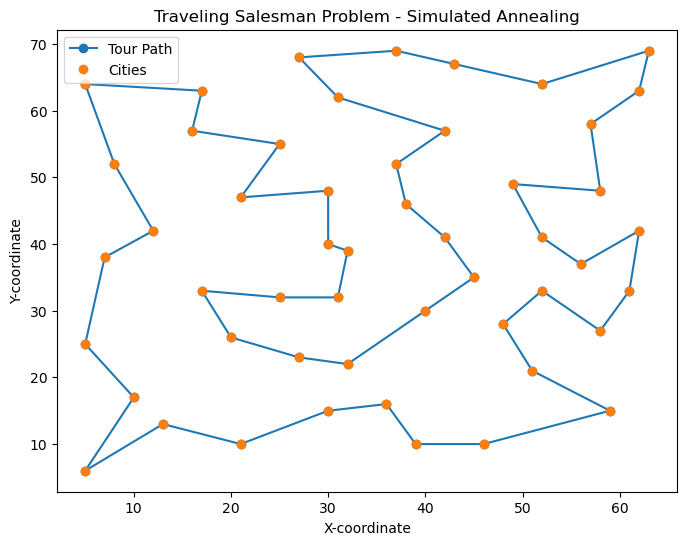

In [33]:
print("Best Tour:", best_tour)
print("Best Distance:", best_distance)
plot_tour(best_tour, cities)

2.2.6 Apply further optimization options on the best_tour

In [34]:
best_route_2opt = optimise_with_2opt(best_tour, cities)
best_dist_2opt = calculate_total_distance(best_route_2opt, cities)
print("Best Distance_2opt:", best_dist_2opt)

Best Distance_2opt: 428.8717563920339


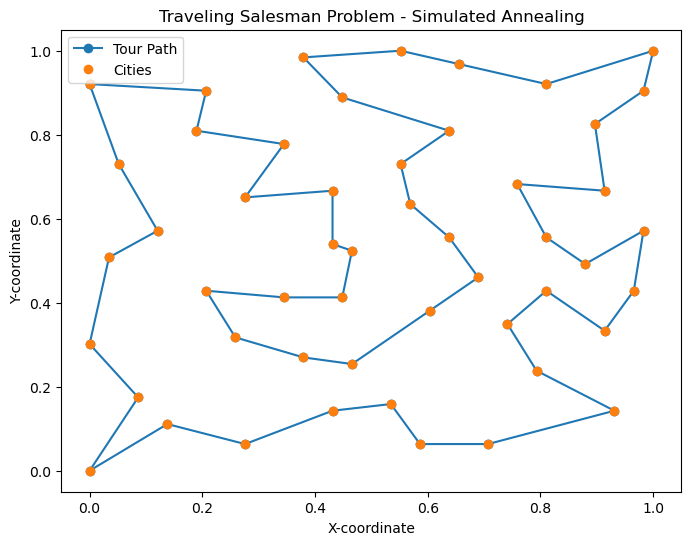

In [35]:
coord_denorm = list(zip(x, y))
plot_tour(best_tour, cities_norm)

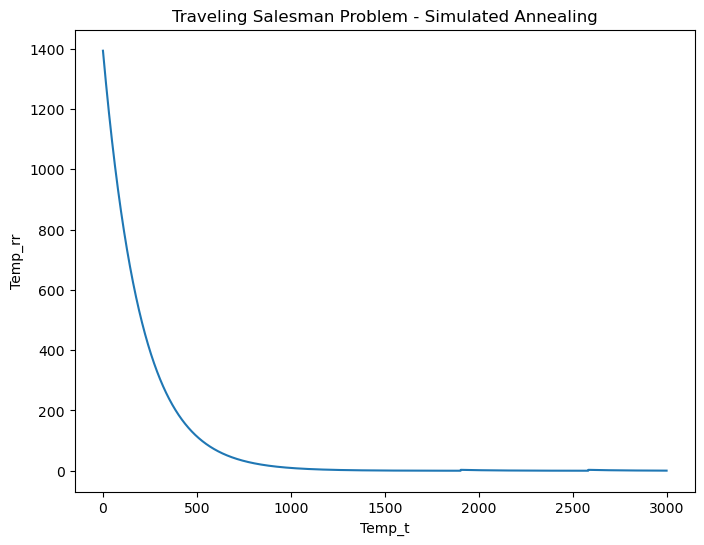

In [36]:
plt.figure(figsize=(8, 6))
plt.plot(temp_t, temp_arr)
plt.title('Traveling Salesman Problem - Simulated Annealing - EL51')
plt.xlabel('Temp_t')
plt.ylabel('Temp_rr')
plt.show()

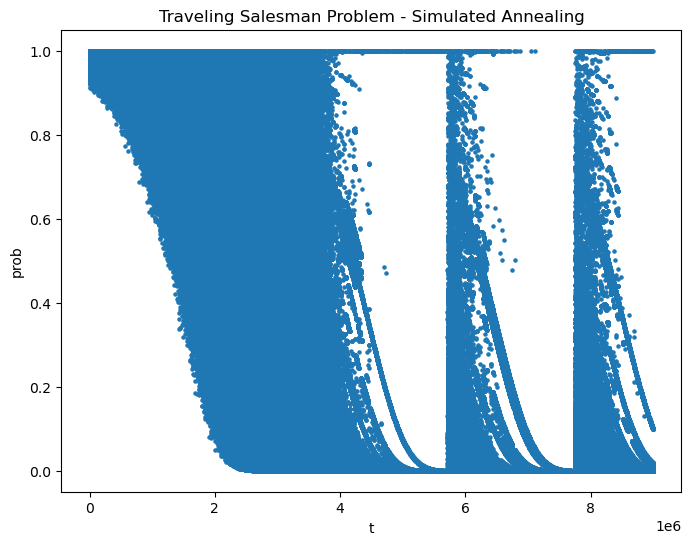

In [37]:
plt.figure(figsize=(8, 6))
plt.scatter(t, prob, s=5, label='Data Points')
plt.title('Traveling Salesman Problem - Simulated Annealing - EL51')
plt.xlabel('t')
plt.ylabel('prob')
plt.show()

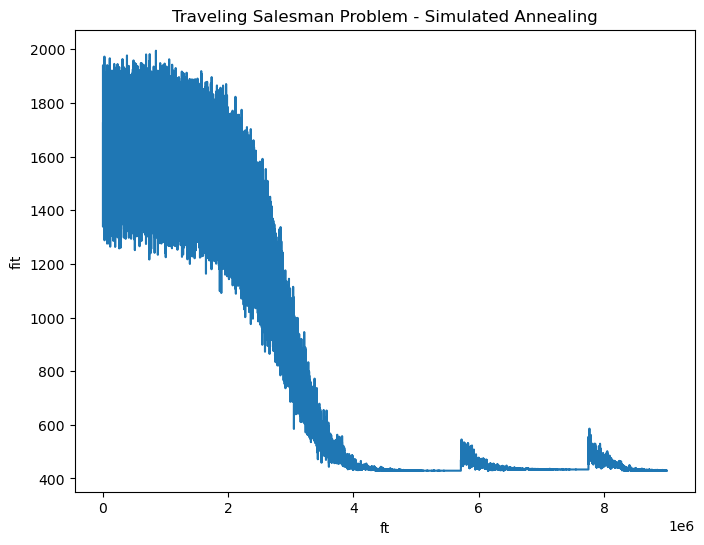

In [38]:
plt.figure(figsize=(8, 6))
plt.plot(ft, fit)
plt.title('Traveling Salesman Problem - Simulated Annealing - EL51')
plt.xlabel('ft')
plt.ylabel('fit')
plt.show()

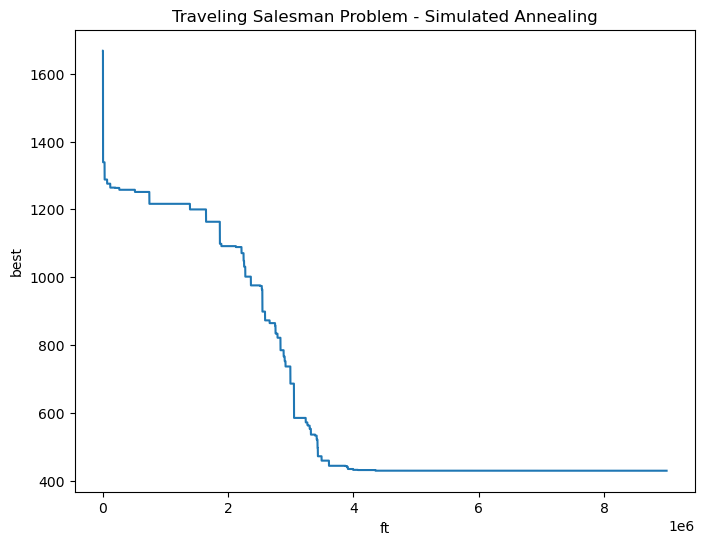

In [39]:
plt.figure(figsize=(8, 6))
plt.plot(ft, best)
plt.title('Traveling Salesman Problem - Simulated Annealing - EL51')
plt.xlabel('ft')
plt.ylabel('best')
plt.show()

In [40]:
print(best_dist_2opt)

428.8717563920339


2.3.X Run the simulated annealing method with the 2-opt and move-city corrections

Best Tour: [32, 26, 16, 10, 43, 19, 34, 11, 44, 38, 35, 33, 7, 27, 2, 45, 49, 23, 47, 0, 28, 6, 46, 12, 36, 9, 30, 25, 41, 1, 37, 42, 50, 39, 29, 8, 48, 31, 14, 18, 13, 24, 4, 17, 21, 40, 5, 15, 3, 20, 22]
Best Distance: 1275.3301624262504


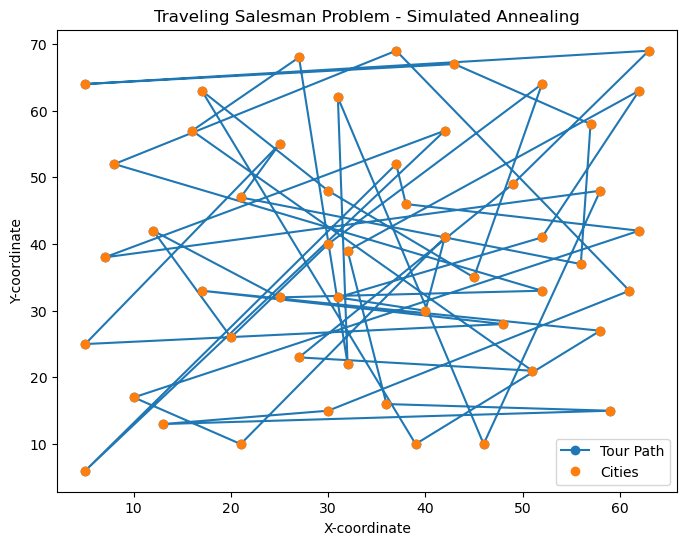

In [41]:
best_tour, best_distance = simulated_annealing_tomc(cities)
print("Best Tour:", best_tour)
print("Best Distance:", best_distance)
plot_tour(best_tour, cities)

This is not the result we want.

2.3.2 Run multiple simulations of simulated annealing method with the 2-opt and move-city corrections

Best Tour: [8, 44, 42, 41, 4, 10, 47, 6, 19, 34, 45, 50, 48, 29, 0, 5, 3, 14, 46, 32, 25, 27, 30, 21, 49, 13, 1, 35, 18, 43, 40, 11, 33, 12, 38, 37, 9, 17, 23, 2, 31, 7, 15, 22, 20, 36, 26, 24, 28, 39, 16]
Best Distance: 1137.643359501912


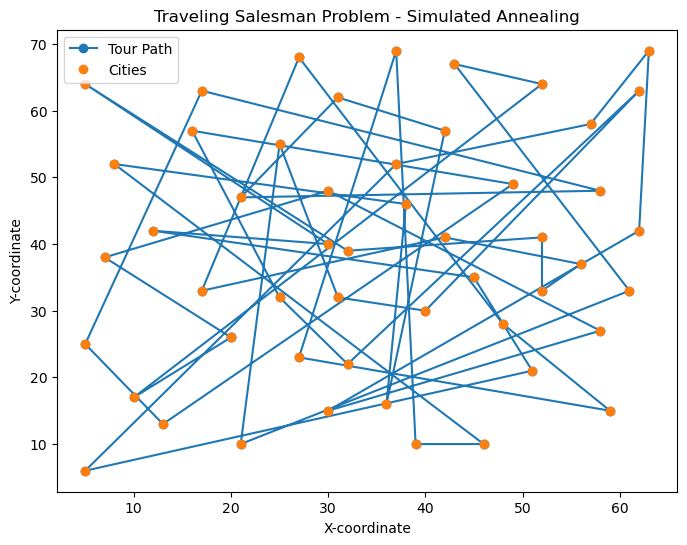

In [42]:
best_tour, best_distance = run_multiple_simulations_tomc(cities, num_simulations=3000)
print("Best Tour:", best_tour)
print("Best Distance:", best_distance)
plot_tour(best_tour, cities)

This is not the result we want.

## 3. Test Runs: TSP - Configuration: A280

In [45]:
# the name of the csv file you want to read
file_name = 'a280.tsp.txt'

# combine the folder path and file name to create the file path
file_path_a280 = folder_path + file_name

In [46]:
tsp_file_path_a280 = file_path_a280
cities_a280 = read_tsp_file(tsp_file_path_a280)
random.shuffle(cities_a280)
cities_norm_a280 = normalise_dist(cities_a280)
    
initial_temp = 1400
cooling_rate = 0.995 

3.1 Run simulated annealing method with a fixed cooling rate.

In [47]:
best_tour, best_distance, temp_arr, prob, t, fit, ft, temp_t, best = simulated_annealing(cities_a280, initial_temp, cooling_rate)

34328.41765367596
34228.4345475669
34171.434479463234
34010.040528793594
33885.73761754567
33878.584784394865
33771.137621965194
33713.71430696695
33710.980303408294
33701.682022438625
33540.834818250274
33492.13783967803
33392.16668939354
33275.80662618856
33193.508822503085
33085.155599748054
33016.120990865835
32873.07005209388
32642.21175992528
32636.372707961174
32619.672032008824
32590.262510790926
32483.89748570099
32483.396922353742
32469.222784981877
32450.051193519736
32409.449353517783
32385.584565002082
32346.83449088674
32304.521775178502
32093.34010455103
32055.829411237773
31886.444651005466
31857.374181290215
31772.75864113241
31747.888048229
31705.830106568636
31606.115561994935
31565.359526596996
31563.353687280458
31560.03086480189
31459.941144394976
31437.77785775603
31287.35291064454
31180.020376573695
31176.799038382025
31169.027288475176
31133.469979171907
31083.070869255745
31054.339767272977
30972.409716498587
30811.38555653528
30735.31958898881
30724.693183614

12675.281749966822
12656.841838465558
12619.065955785805
12601.222953256442
12583.20350846706
12565.879307982292
12564.024599215494
12561.322436367593
12553.896407110818
12496.78902322943
12492.454273466446
12485.498501407385
12465.086840428072
12464.979390452161
12455.967673661935
12351.061215110563
12332.057048644292
12268.646868355696
12232.272653243763
12187.266214955522
12186.258182665953
12140.966583470825
12085.76797242155
12060.008652894827
12015.106765936389
12014.318152071617
12001.667490734375
11974.394541907588
11878.388801623803
11868.146654020915
11859.429354827935
11790.638632392747
11775.876613221497
11733.319305189316
11717.088005565593
11692.688257061132
11681.532667264846
11676.34773499879
11660.40145249057
11615.240396541014
11581.752572554533
11565.639545221005
11548.40713090163
11546.729258572666
11539.692750566704
11499.282042353017
11472.621355059655
11440.969392038722
11381.589234844494
11372.291013563146
11365.991874321076
11363.092339707811
11350.321445841248

5806.830934674168
5798.4383583957315
5794.690258527556
5783.868998478572
5777.757542298571
5766.174323657118
5756.28577983712
5750.5517309101415
5737.3291625810025
5724.563687987443
5700.197493021354
5693.802556446764
5685.295903856319
5664.699516537779
5659.541624676324
5656.391506667348
5638.917926791858
5638.648649321252
5629.645038404228
5619.393147422998
5619.039294279018
5610.531129711553
5588.079673994569
5579.096051929496
5578.192353114438
5548.472527586857
5541.298821802106
5534.438924380757
5533.947108451761
5495.835652271759
5493.512181645197
5493.043266837937
5485.08459317695
5481.770884677965
5478.867599971208
5469.092958645447
5465.437218499105
5446.715587978178
5441.495306597808
5435.249095346573
5422.496461865657
5409.6934772772465
5404.491224958263
5400.899407931893
5385.687313023862
5360.90622245202
5353.271061845233
5337.271061845233
5316.798362043293
5315.67789404511
5304.954508084774
5302.027028357771
5286.617350896423
5276.880518790361
5268.82981193461
5267.035093

2997.575652555952
2988.150487876965
2980.150487876965
2973.7698531321357
2972.6988690741573
2972.466388650777
2970.1958043786276
2968.1803171609895
2967.3366589016578
2965.4481150816596
2965.3060866105307
2959.828153418674
2954.3502202268173
2949.6639287258017
2947.1482748048666
2941.8753788250892
2940.4502141461026
2940.3706536391537
2939.7803311005027
2933.152914102533
2931.137426884895
2923.0756209673114
2919.7619124683265
2919.4399668978785
2915.6628792578827
2909.3103285895727
2909.2940982199016
2905.9803897209167
2901.2940982199016
2899.868933540915
2897.471748242592
2895.6868756140143
2889.0594586160446
2887.147034475371
2881.944782156388
2877.2584906553725
2873.997363833344
2870.4576218503394
2868.5690780303407
2863.8827865293256
2857.4492385299004
2856.7029720204255
2854.7591978167634
2854.298608530997
2853.0814194747986
2851.7088364727683
2850.7010928639497
2850.7010928639493
2848.2788877620933
2842.8009545702366
2840.9124107502385
2840.290347831515
2835.6040563305
2831.03946

In [48]:
x = [cities_a280[city][0] for city in best_tour]
y = [cities_a280[city][1] for city in best_tour]
x.append(x[0])
y.append(y[0])

In [49]:
best_distance = calculate_total_distance(best_tour, cities_a280)

Best Tour for A280: [0, 71, 129, 88, 226, 246, 78, 167, 215, 95, 13, 37, 174, 181, 147, 48, 15, 140, 274, 10, 184, 266, 53, 265, 62, 123, 245, 117, 202, 81, 156, 171, 259, 38, 201, 124, 250, 80, 76, 50, 155, 11, 101, 150, 113, 51, 236, 249, 214, 23, 34, 63, 105, 276, 144, 185, 138, 27, 18, 232, 191, 2, 194, 7, 190, 254, 146, 54, 165, 8, 164, 172, 49, 189, 263, 161, 111, 205, 158, 87, 109, 277, 244, 116, 42, 262, 159, 21, 97, 260, 279, 86, 135, 207, 196, 56, 199, 75, 132, 241, 72, 108, 272, 40, 230, 73, 176, 152, 186, 270, 258, 19, 17, 143, 239, 197, 192, 136, 31, 28, 118, 183, 84, 261, 209, 121, 219, 12, 203, 94, 163, 247, 149, 268, 218, 216, 231, 74, 20, 166, 179, 24, 59, 47, 60, 193, 77, 100, 46, 256, 217, 131, 252, 82, 127, 221, 211, 153, 275, 237, 157, 175, 141, 238, 41, 119, 114, 4, 29, 206, 103, 195, 145, 234, 182, 43, 3, 248, 210, 93, 68, 251, 160, 264, 169, 154, 30, 188, 112, 9, 224, 255, 110, 106, 55, 107, 240, 269, 229, 212, 257, 125, 35, 69, 33, 133, 83, 177, 120, 61, 222, 1

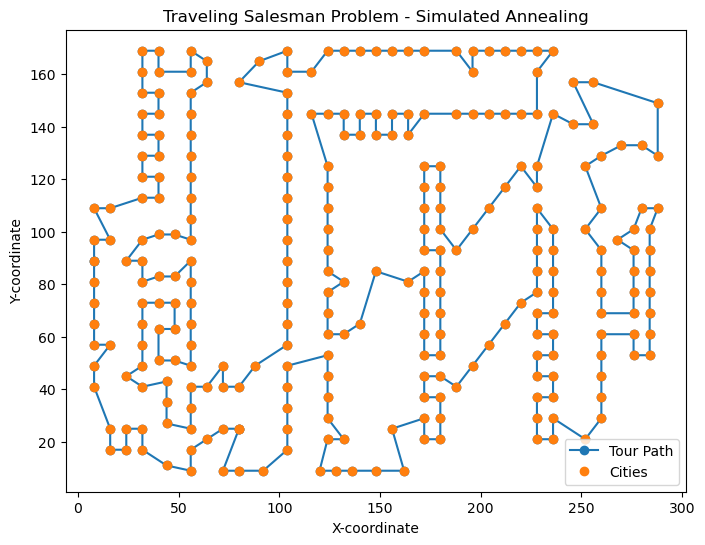

In [50]:
print("Best Tour for A280:", best_tour)
print("Best Distance for A280:", best_distance)
plot_tour(best_tour, cities_a280)

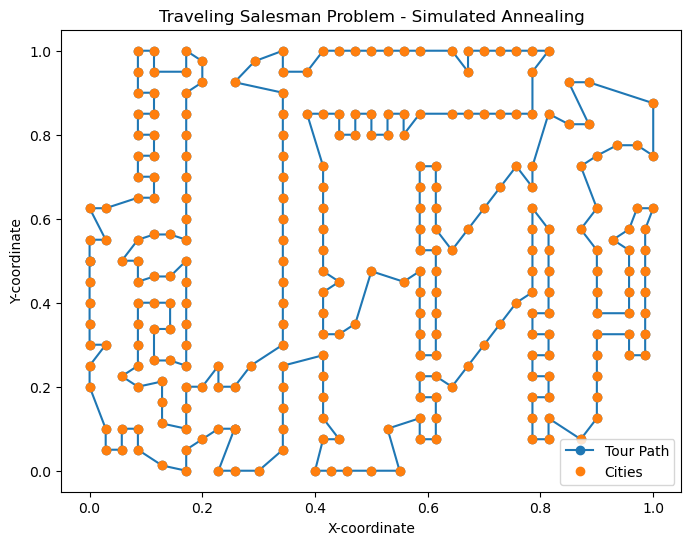

In [51]:
coord_denorm = list(zip(x, y))
plot_tour(best_tour, cities_norm_a280)

In [52]:
best_route_2opt = optimise_with_2opt(best_tour, cities_a280)
best_dist_2opt = calculate_total_distance(best_route_2opt, cities_a280)
print("Best Distance_2opt:", best_dist_2opt)

Best Distance_2opt: 2659.7205734629856


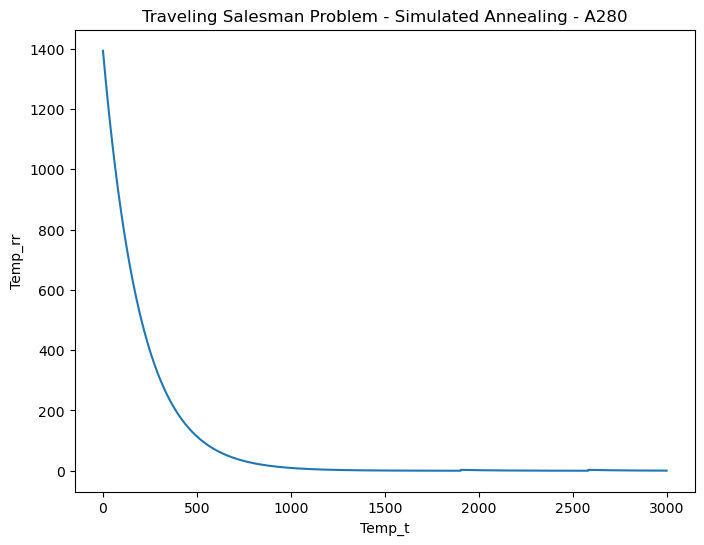

In [53]:
plt.figure(figsize=(8, 6))
plt.plot(temp_t, temp_arr)
plt.title('Traveling Salesman Problem - Simulated Annealing - A280')
plt.xlabel('Temp_t')
plt.ylabel('Temp_rr')
plt.show()

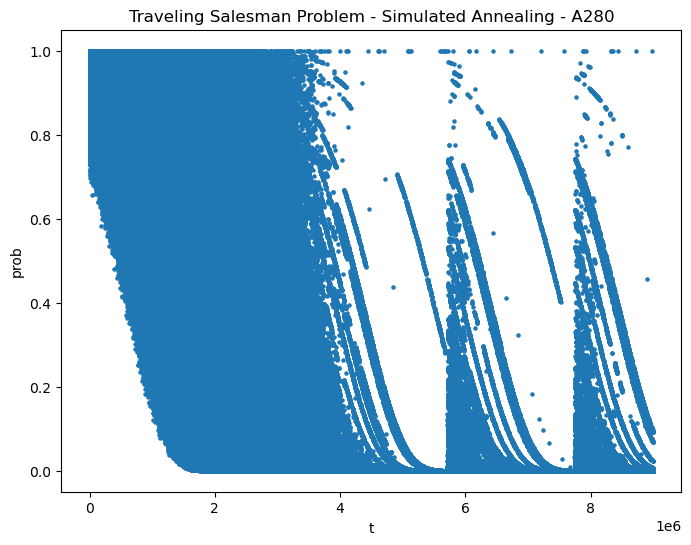

In [54]:
plt.figure(figsize=(8, 6))
plt.scatter(t, prob, s=5, label='Data Points')
plt.title('Traveling Salesman Problem - Simulated Annealing - A280')
plt.xlabel('t')
plt.ylabel('prob')
plt.show()

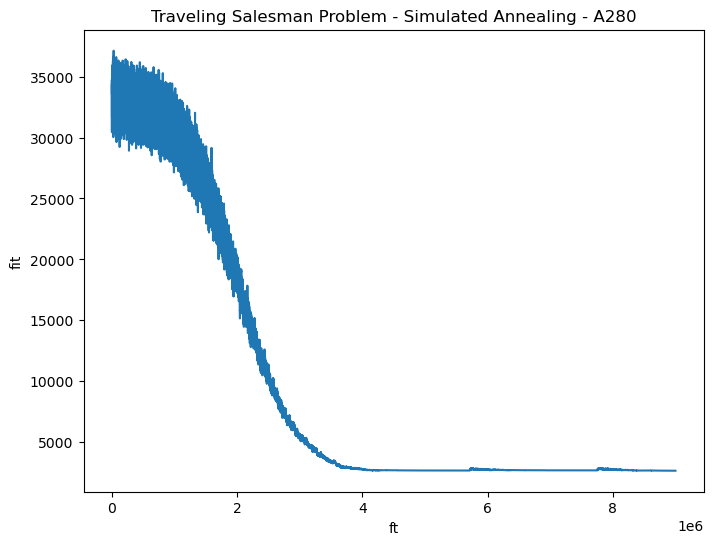

In [55]:
plt.figure(figsize=(8, 6))
plt.plot(ft, fit)
plt.title('Traveling Salesman Problem - Simulated Annealing - A280')
plt.xlabel('ft')
plt.ylabel('fit')
plt.show()

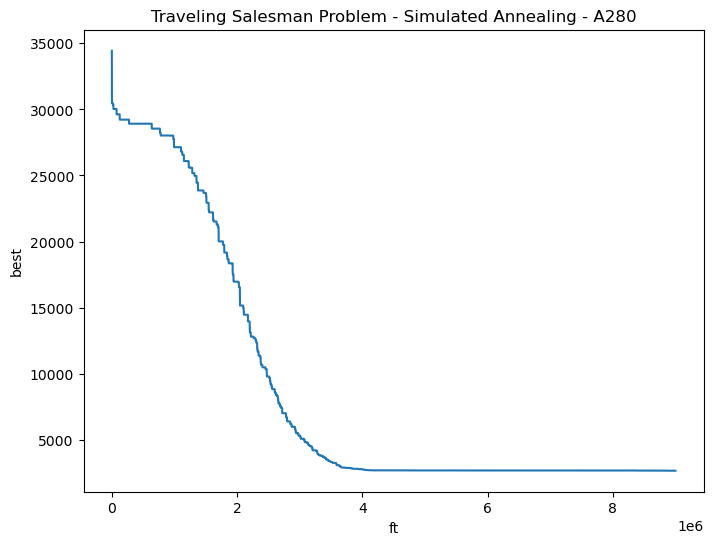

In [56]:
plt.figure(figsize=(8, 6))
plt.plot(ft, best)
plt.title('Traveling Salesman Problem - Simulated Annealing - A280')
plt.xlabel('ft')
plt.ylabel('best')
plt.show()

In [58]:
print(best_dist_2opt)

2659.7205734629856


3.1 Run simulated annealing method with an exponential cooling schedule.

In [60]:
initial_temp_list = simulated_annealing_initial(cities_a280)

Function Took 82.5158 seconds
Best Tour for A280 with the exponential cooling schedule: [0, 90, 235, 64, 148, 44, 5, 126, 22, 253, 66, 168, 6, 98, 25, 99, 220, 36, 194, 7, 190, 254, 213, 130, 223, 151, 85, 104, 89, 32, 52, 180, 1, 149, 247, 163, 203, 94, 216, 218, 268, 16, 170, 102, 198, 65, 115, 242, 173, 142, 225, 45, 26, 92, 14, 200, 178, 128, 233, 24, 179, 47, 59, 278, 122, 39, 70, 204, 208, 193, 60, 166, 20, 231, 74, 77, 46, 256, 217, 131, 252, 19, 239, 197, 31, 28, 84, 183, 118, 136, 192, 143, 17, 258, 82, 127, 221, 211, 100, 153, 275, 237, 157, 175, 176, 73, 230, 41, 119, 114, 145, 234, 182, 238, 141, 267, 137, 58, 273, 187, 57, 243, 227, 228, 91, 271, 134, 162, 67, 96, 79, 222, 139, 120, 61, 33, 177, 83, 133, 69, 35, 125, 257, 212, 229, 68, 93, 251, 269, 240, 107, 55, 106, 110, 160, 264, 255, 224, 169, 210, 248, 3, 43, 154, 30, 9, 188, 112, 103, 195, 206, 29, 4, 272, 40, 108, 72, 241, 132, 75, 199, 152, 186, 270, 56, 196, 207, 135, 86, 279, 260, 97, 21, 159, 262, 42, 116, 244, 

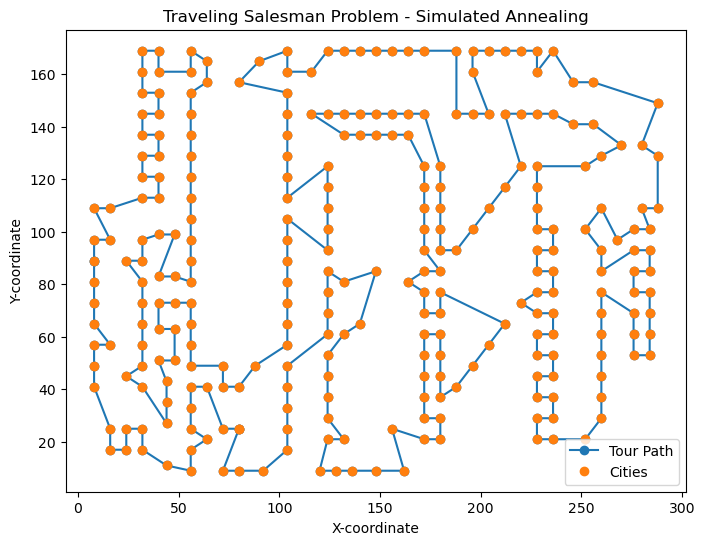

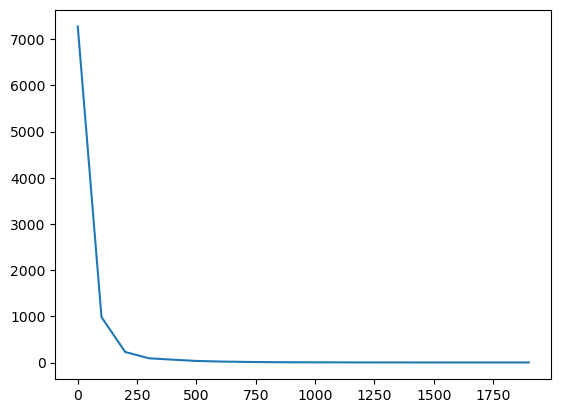

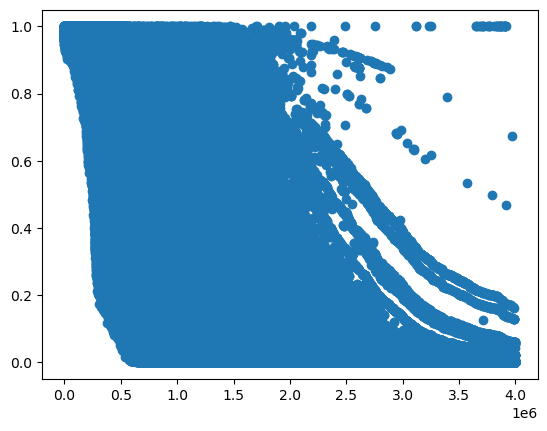

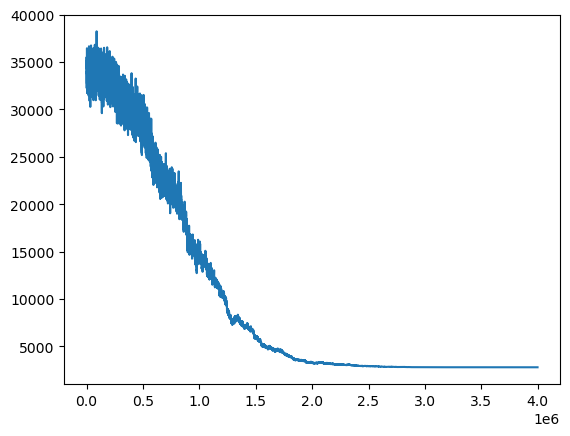

ValueError: x and y must have same first dimension, but have shapes (204592,) and (20,)

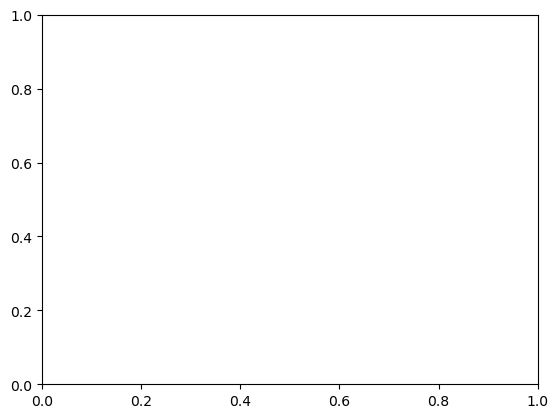

In [63]:
initial_temp = 0
cooling_rate = 0
best_tour, best_distance, temp_arr, prob, t, fit, ft, temp_t, best = simulated_annealing_list(cities_a280,initial_temp,cooling_rate, exponential_cooling, initial_temp_list)
best_distance = calculate_total_distance(best_tour, cities_a280)

print("Best Tour for A280 with the exponential cooling schedule:", best_tour)
print("Best Distance for A280 with the exponential cooling schedule:", best_distance)
plot_tour(best_tour, cities_a280)

plt.plot(temp_t, temp_arr)
plt.show()
plt.scatter(t, prob)
plt.show()
plt.plot(ft, fit)
plt.show()
plt.plot(ft, best)
plt.yscale('log')
plt.show()

DESCRIPTION_PLACEHOLDER

In [ ]:
types = [exponential_cooling, fast_cooling]
best_distance_list = []
temp_arrs_list = []
fit_arr_list = []
temp_t_arr_list = []
prob_arr_list = []
t_arr_list = []
ft_arr_list = []
best_arr_list = []
best_tour_arr_list = []
temp_arr_list = []

best_distance_file = 'best_distance_list.csv'
temp_file = 'temp_list.csv'
best_arr_lis = 'best_arr_list.csv'

for _ in range(30):
        tsp_file_path = file_path
        cities = read_tsp_file(tsp_file_path)
        random.shuffle(cities)
        initial_temp_list = simulated_annealing_initial(cities)
        initial_temp = 1400
        cooling_rate = 0.995
        best_tour, best_distance, temp_arr, prob, t, fit, ft, temp_t, best,   = simulated_annealing_list(cities,initial_temp,cooling_rate,fast_cooling, initial_temp_list)
        with open(best_distance_file, 'a', newline='') as bd_file:
            bd_writer = csv.writer(bd_file)
            bd_writer.writerow([best_distance])
        with open(temp_file, 'a', newline='') as bd_file:
            bd_writer = csv.writer(bd_file)
            bd_writer.writerow([temp_arr])
        with open(best_arr_lis, 'a', newline='') as bd_file:
            bd_writer = csv.writer(bd_file)
            bd_writer.writerow([best])

In [ ]:
best_distance_file_fast_cooling = 'best_distance_arr_fast_cooling.csv'
temp_file_fast_cooling = 'temp_fast_cooling.csv'
best_arr_fast_cooling = 'best_arr_fast_cooling.csv'

for iteration in range(30):
        tsp_file_path = file_path
        cities = read_tsp_file(tsp_file_path)
        random.shuffle(cities)
        initial_temp = 1400
        cooling_rate = 0.995
        best_tour, best_distance, temp_arr, prob, t, fit, ft, temp_t, best = simulated_annealing_cooling_check(cities, initial_temp, cooling_rate, fast_cooling)

        with open(best_distance_file_fast_cooling, 'a', newline='') as bd_file:
            bd_writer = csv.writer(bd_file)
            bd_writer.writerow([best_distance])
        with open(temp_file_fast_cooling, 'a', newline='') as bd_file:
            bd_writer = csv.writer(bd_file)
            bd_writer.writerow([temp_arr])
        with open(best_arr_fast_cooling, 'a', newline='') as bd_file:
            bd_writer = csv.writer(bd_file)
            bd_writer.writerow([best])

In [ ]:
best_distanceexp= 'best_distance_arr_fexpon.csv'
temp_fileexp= 'temp_fastexpon.csv'
best_arrexp = 'best_arr_fast_expon.csv'
for _ in range(30):
    tsp_file_path = file_path
    cities = read_tsp_file(tsp_file_path)
    random.shuffle(cities)
    initial_temp = 1400
    cooling_rate = 0.995
    best_tour, best_distance, temp_arr, prob, t, fit, ft, temp_t, best  = simulated_annealing_cooling_check(cities,initial_temp,cooling_rate,exponential_cooling)
    
    with open(best_distanceexp, 'a', newline='') as bd_file:
            bd_writer = csv.writer(bd_file)
            bd_writer.writerow([best_distance])
    with open(temp_fileexp, 'a', newline='') as bd_file:
            bd_writer = csv.writer(bd_file)
            bd_writer.writerow([temp_arr])
    with open(best_arrexp, 'a', newline='') as bd_file:
            bd_writer = csv.writer(bd_file)
            bd_writer.writerow([best])

### 2.3.1 Length of the Markov Chain

## 3. Test Runs: TSP - Configuration: PCB442

In [ ]:
# the name of the csv file you want to read
file_name = 'pcb442.tsp.txt'

# combine the folder path and file name to create the file path
file_path_pcb442 = folder_path + file_name

In [ ]:
tsp_file_path_pcb442 = file_path_pcb442
cities_pcb442 = read_tsp_file(tsp_file_path_pcb442)
random.shuffle(cities_pcb442)
cities_norm_pcb442 = normalise_dist(cities_pcb442)
    
initial_temp = 1400
cooling_rate = 0.995 

In [ ]:
best_tour_pcb442, best_distance_pcb442, temp_arr, prob, t, fit, ft, temp_t, best_pcb442 = simulated_annealing(cities_pcb442,initial_temp,cooling_rate)

In [ ]:
x = [cities_pcb442[city][0] for city in best_tour_pcb442]
y = [cities_pcb442[city][1] for city in best_tour_pcb442]
x.append(x[0])
y.append(y[0])

In [ ]:
best_distance_pcb442 = calculate_total_distance(best_tour_pcb442, cities_pcb442)

In [ ]:
print("Best Tour for PCB442:", best_tour_pcb442)
print("Best Distance for PCB442:", best_distance_pcb442)
plot_tour(best_tour_pcb442, cities_pcb442)

In [ ]:
coord_denorm = list(zip(x, y))
plot_tour(best_tour_pcb442, cities_norm_pcb442)

In [ ]:
best_route_2opt_pcb442 = optimise_with_2opt(best_tour_pcb442, cities_pcb442)
best_dist_2opt_pcb442 = calculate_total_distance(best_route_2opt_pcb442, cities_pcb442)
print("Best Distance_2opt for PCB442:", best_dist_2opt_pcb442)

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(temp_t, temp_arr)
plt.title('Traveling Salesman Problem - Simulated Annealing - PCB442')
plt.xlabel('Temp_t')
plt.ylabel('Temp_rr')
plt.show()

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(t, prob, s=5, label='Data Points')
plt.title('Traveling Salesman Problem - Simulated Annealing - PCB442')
plt.xlabel('t')
plt.ylabel('prob')
plt.show()

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(ft, fit)
plt.title('Traveling Salesman Problem - Simulated Annealing - PCB442')
plt.xlabel('ft')
plt.ylabel('fit')
plt.show()

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(ft, best_pcb442)
plt.title('Traveling Salesman Problem - Simulated Annealing - PCB442')
plt.xlabel('ft')
plt.ylabel('best')
plt.show()

In [ ]:
tor = [1,
2,
242,
243,
244,
241,
240,
239,
238,
237,
236,
235,
234,
233,
232,
231,
246,
245,
247,
250,
251,
230,
229,
228,
227,
226,
225,
224,
223,
222,
221,
220,
219,
218,
217,
216,
215,
214,
213,
212,
211,
210,
207,
206,
205,
204,
203,
202,
201,
198,
197,
196,
195,
194,
193,
192,
191,
190,
189,
188,
187,
186,
185,
184,
183,
182,
181,
176,
180,
179,
150,
178,
177,
151,
152,
156,
153,
155,
154,
129,
130,
131,
20,
21,
128,
127,
126,
125,
124,
123,
122,
121,
120,
119,
157,
158,
159,
160,
175,
161,
162,
163,
164,
165,
166,
167,
168,
169,
170,
172,
171,
173,
174,
107,
106,
105,
104,
103,
102,
101,
100,
99,
98,
97,
96,
95,
94,
93,
92,
91,
90,
89,
109,
108,
110,
111,
112,
88,
87,
113,
114,
115,
117,
116,
86,
85,
84,
83,
82,
81,
80,
79,
78,
77,
76,
75,
74,
73,
72,
71,
70,
69,
68,
67,
66,
65,
64,
58,
57,
56,
55,
54,
53,
52,
51,
50,
49,
48,
47,
46,
45,
44,
59,
63,
62,
118,
61,
60,
43,
42,
41,
40,
39,
38,
37,
36,
35,
34,
33,
32,
31,
30,
29,
28,
27,
26,
22,
25,
23,
24,
14,
15,
13,
12,
11,
10,
9,
8,
7,
6,
5,
4,
277,
276,
275,
274,
273,
272,
271,
16,
17,
18,
19,
132,
133,
134,
270,
269,
135,
136,
268,
267,
137,
138,
139,
149,
148,
147,
146,
145,
199,
200,
144,
143,
142,
141,
140,
266,
265,
264,
263,
262,
261,
260,
259,
258,
257,
254,
253,
208,
209,
252,
255,
256,
249,
248,
278,
279,
3,
280
]